2D Poisson equation: $\Delta u = f = u_{xx}+u_{yy}$ <br> 
x element of [0,1] <br> y element of [0,1] <br>
u(0,x) = rand[.1,.9] <br> u(1,x) = rand[.1,.9] <br> u(y,0) = rand[.1,.9] <br> u(y,1) = rand[.1,.9], <br> f(x,y) = $\delta(x-0.5,y-0.5)$ = rand[.1,.9]

Discretized equation with 5-point scheme: $\frac{u^{j}_{i-1}-2u^{j}_{i}+u^{j}_{i+1}}{\Delta x^2} + \frac{u^{j-1}_{i}-2u^{j}_{i}+u^{j+1}_{i}}{\Delta y^2}
= \delta(x-0.5,y-0.5) $ <br>

The Dirac delta function is evaluated by setting the center point to the random draw if fidelity is odd or setting the center 2x2 grid to the value if it is even. 

$\Delta y = \Delta x$

-> $4u^j_i - u^j_{i-1} - u^{j-1}_i - u^j_{i+1} - u^{j+1}_i = \Delta x^2 \delta(x-0.5,y-0.5)$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

In [4]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
import time

In [5]:
def poisson_solver(fidelity,u_0_x,u_1_x,u_y_0,u_y_1,u_dirac):
    # Modifing fidelity so that the BC are included in the result and its easy to change back
    fidelity = fidelity - 2
    
    x = np.linspace(0,1,fidelity)
    dx = x[1]-x[0]
    y = np.linspace(0,1,fidelity)
    u = np.zeros((fidelity+2,fidelity+2)) # Initial u used to create the b-vector in Ax = b
    # BC's and dirac delta
    u[0,:] = u_0_x
    u[-1,:] = u_1_x
    u[:,0] = u_y_0
    u[:,-1] = u_y_1
    
    if fidelity%2 == 0:
        u[int((fidelity+2)/2-1):int((fidelity+2)/2+1),int((fidelity+2)/2-1):int((fidelity+2)/2+1)] = u_dirac/4
    else:
        u[int((fidelity+1)/2),int((fidelity+1)/2)] = u_dirac

    # 5-point scheme
    A = np.zeros((fidelity**2,fidelity**2))
    for i in range(fidelity**2):
        A[i,i] = 4
        if i < fidelity**2-1:
            if i%fidelity != fidelity-1:
                A[i,i+1] = -1
            if i%fidelity != 0 & i-1 >= 0:
                A[i,i-1] = -1
        if i < fidelity**2-fidelity:
            A[i,i+fidelity] = -1
            if i-fidelity >= 0:
                A[i,i-fidelity] = -1
    print(A)
    # Boundry conditions
    g = np.zeros((fidelity,fidelity))
    for i in range(1,fidelity+1):
        for j in range(1,fidelity+1):
            g[i-1,j-1] = u[i-1,j]+u[i+1,j]+u[i,j-1]+u[i,j+1]

    b = dx**2*g.flatten()
    x = np.linalg.solve(A,b)
    u_interior = x.reshape(fidelity,fidelity)
    u_out = u.copy()
    u_out[1:-1,1:-1] = u_interior # Replace solved interior points in u which already includeds BC's
    
    A_s = csc_matrix(A, dtype=float) # s for sparse
    b_s = csc_matrix(b, dtype=float)
    x_s = spsolve(A_s,b_s.T)
    u_s_interior = x_s.reshape(fidelity,fidelity)
    u_s_out = u.copy()
    u_s_out[1:-1,1:-1] = u_s_interior # Replace solved interior points in u which already includeds BC's
    print(u_out)
    return u_out, u_s_out,g

[[ 4. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0.  0.  4.]]
[[5.00000000e+00 1.00000000e-01 1.00000000e-01 ... 1.00000000e-01
  1.00000000e-01 5.00000000e+00]
 [5.00000000e+00 6.85286801e-04 4.24996446e-04 ... 4.24996413e-04
  6.85286785e-04 5.00000000e+00]
 [5.00000000e+00 9.45551457e-04 6.85248253e-04 ... 6.85248187e-04
  9.45551424e-04 5.00000000e+00]
 ...
 [5.00000000e+00 8.08597221e-04 5.06670480e-04 ... 4.99739615e-04
  7.97421952e-04 5.00000000e+00]
 [5.00000000e+00 3.89560221e-04 1.33892592e-04 ... 1.24923489e-04
  3.56087073e-04 5.00000000e+00]
 [5.00000000e+00 3.00000000e-01 3.00000000e-01 ... 3.00000000e-01
  3.00000000e-01 5.00000000e+00]]
--- 0.4247145652770996 seconds ---


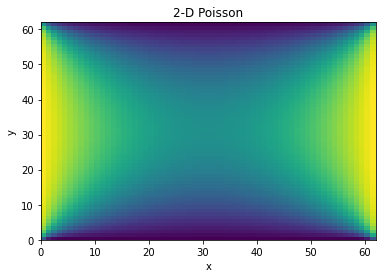

In [13]:
# Initial Conditions
fidelity = 64
# BC's
#u_0_x = np.random.uniform(.1,.9)
#u_1_x = np.random.uniform(.1,.9)
#u_y_0 = np.random.uniform(.1,.9)
#u_y_1 = np.random.uniform(.1,.9)
#u_dirac = np.random.uniform(.1,.9)

u_0_x = .1
u_1_x = .3
u_y_0 = 5
u_y_1 = 5
u_dirac = 0

start_time = time.time()
u, u_s,g = poisson_solver(fidelity,u_0_x,u_1_x,u_y_0,u_y_1,u_dirac)
print("--- %s seconds ---" % (time.time() - start_time))


plt.pcolormesh(np.flipud(u_s[1:-1,1:-1]))
plt.xlabel('x')
plt.ylabel('y')
plt.title('2-D Poisson')
plt.show()

#plt.pcolormesh(np.flipud(u_s))
#plt.xlabel('x')
#plt.ylabel('y')
#plt.title('2-D Poisson')
#plt.show()

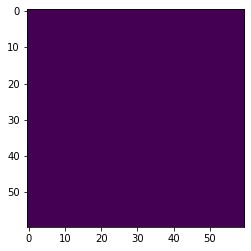

In [12]:
plt.figure()
plt.imshow(g[1:-1,1:-1])

In [9]:
g

array([[5.1, 0.1, 0.1, ..., 0.1, 0.1, 5.1],
       [5. , 0. , 0. , ..., 0. , 0. , 5. ],
       [5. , 0. , 0. , ..., 0. , 0. , 5. ],
       ...,
       [5. , 0. , 0. , ..., 0. , 0. , 5. ],
       [5. , 0. , 0. , ..., 0. , 0. , 5. ],
       [5.3, 0.3, 0.3, ..., 0.3, 0.3, 5.3]])

In [5]:
u[1:-1,1:-1]
u[8,8]

0.0006844779565051552

In [ ]:
u_hh = poisson_solver(fidelity*6,u_0_x,u_1_x,u_y_0,u_y_1,u_dirac)
plt.pcolormesh(np.flipud(u_hh))
plt.xlabel('x')
plt.ylabel('y')
plt.title('2-D Poisson')
plt.show()

[[ 4. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0.  0.  4.]]


In [ ]:
# Interpolate onto higher mesh grid
x = np.linspace(0,1,fidelity)
y = np.linspace(0,1,fidelity)
high_res_u = scipy.interpolate.interp2d(x,y,u,kind='cubic')

# Higher mesh test points
x_h = np.linspace(0,1,fidelity*6)
y_h = np.linspace(0,1,fidelity*6)
u_h = high_res_u(x_h,y_h)

In [ ]:
print(u.shape)
print(u_h.shape)

In [ ]:
plt.pcolormesh(np.flipud(u_h))
plt.xlabel('x')
plt.ylabel('y')
plt.title('2-D Poisson (with interpolation onto higher mesh grid)')
plt.show()